### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL/2_FirstImplementation

### Import libraries

In [ ]:
# Hide warnings
seed  = 42
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

### Load and process the dataset

In [ ]:
# Load data
data = np.load('../clean_data.npz', allow_pickle=True)

# Save images in a new list (image pixel values are float in [0, 1])
images = data['data']

# Save labels in a new list
labels = data['labels']

# Print data shape
print(images.shape, labels.shape)

(5004, 96, 96, 3) (5004,)


In [ ]:
# Convert labels from string to integer
num_labels = []
for label in labels:
  if label == "healthy":
    num_labels.append(0)
  else:
    num_labels.append(1)

# Convert labels in the one-hot encoding format
num_labels = np.array(num_labels)
labels = tfk.utils.to_categorical(num_labels, 2)

### Model

In [ ]:
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

In [ ]:
def build_model(mobile, dropout_rate, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Set the image preprocessing
  preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomZoom(0.05),
        ], name='preprocessing')

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Preprocessing
  preprocessing = preprocessing(inputs)

  # Connect MobileNetV2 to the input
  x = mobile(preprocessing)

  # Hidden layers
  x = tfkl.Dense(units=64, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)
  x = tfkl.Dense(units=64, name='HiddenDense2')(dropout)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(dropout)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
dropout_rate = 1/8

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.999,
    mode='max',
    min_lr=1e-7
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

In [ ]:
# Define the number of folds for cross-validation
num_folds = 20

# Initialize lists to store training histories, scores, and best epochs
histories = []
scores = []
best_epochs = []

# Create a KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Loop through each fold
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(images, labels)):

  print("Starting training on fold num: {}".format(fold_idx+1))

  # Build a new dropout model for each fold
  k_model = build_model(mobile, dropout_rate, 1e-4)

  # Train the model on the training data for this fold
  history = k_model.fit(
    x = preprocess_input(images*255)[train_idx],
    y = labels[train_idx],
    batch_size = 32,
    epochs = 200,
    validation_data=(preprocess_input(images*255)[valid_idx], labels[valid_idx]),
    callbacks = [early_stopping, lr_scheduler],
    verbose = 0
  ).history

  # Evaluate the model on the validation data for this fold
  score = k_model.evaluate(images[valid_idx], labels[valid_idx], verbose=0)
  scores.append(score[1])

  # Calculate the best epoch for early stopping
  best_epoch = len(history['loss']) - 20
  best_epochs.append(best_epoch)

  # Store the training history for this fold
  histories.append(history)

Starting training on fold num: 1
Starting training on fold num: 2
Starting training on fold num: 3
Starting training on fold num: 4
Starting training on fold num: 5
Starting training on fold num: 6
Starting training on fold num: 7
Starting training on fold num: 8
Starting training on fold num: 9
Starting training on fold num: 10
Starting training on fold num: 11
Starting training on fold num: 12
Starting training on fold num: 13
Starting training on fold num: 14
Starting training on fold num: 15
Starting training on fold num: 16
Starting training on fold num: 17
Starting training on fold num: 18
Starting training on fold num: 19
Starting training on fold num: 20


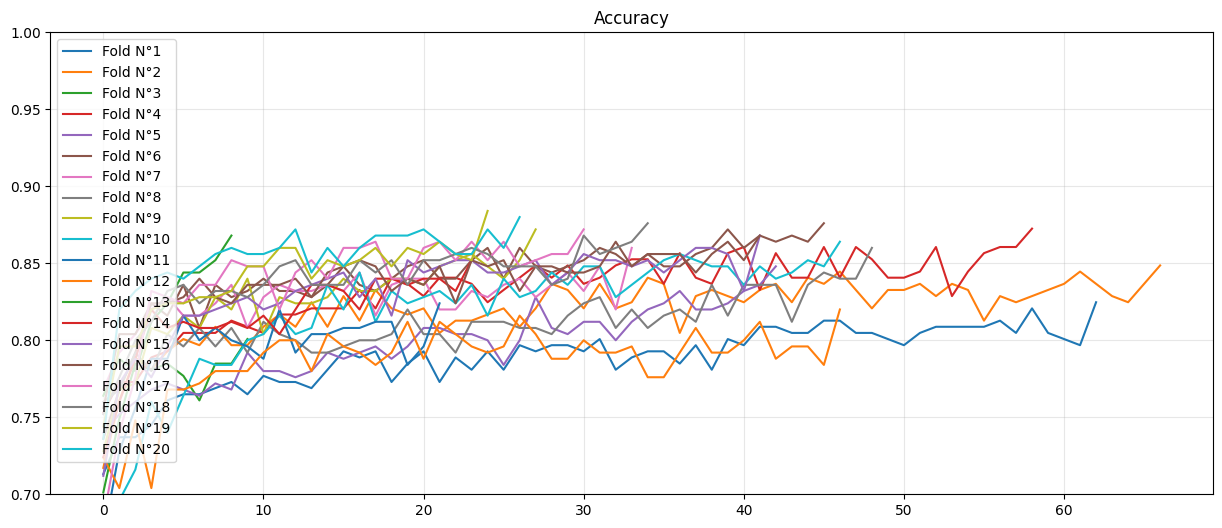

In [ ]:
# Define a list of colors for plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(15,6))

for fold_idx in range(num_folds):
  plt.plot(histories[fold_idx]['val_accuracy'][:-20], color=colors[fold_idx], label=f'Fold N°{fold_idx+1}')
  plt.ylim(0.7, 1.0)
  plt.title('Accuracy')
  plt.legend(loc='upper left')
  plt.grid(alpha=.3)

plt.show()

In [ ]:
# Calculate the average best epoch
print (best_epochs)
avg_epochs = int(np.mean(best_epochs))
print(f"Best average epoch: {avg_epochs}")

[63, 67, 10, 59, 43, 46, 34, 49, 28, 47, 22, 47, 9, 24, 42, 42, 31, 35, 25, 27]
Best average epoch: 37


In [ ]:
# Build the final model using the calculated average best epoch
final_model = build_model(mobile, dropout_rate, 1e-4)

# Train the final model on the combined training and validation data
final_history = final_model.fit(
    x = images,
    y = labels,
    batch_size = 32,
    epochs = avg_epochs,
    callbacks = [lr_scheduler]
).history

Epoch 1/37
157/157 [==============================] - 6s 19ms/step - loss: 0.6455 - accuracy: 0.6337 - lr: 1.0000e-04
Epoch 2/37
157/157 [==============================] - 3s 16ms/step - loss: 0.5489 - accuracy: 0.7236 - lr: 1.0000e-04
Epoch 3/37
157/157 [==============================] - 2s 15ms/step - loss: 0.5160 - accuracy: 0.7420 - lr: 1.0000e-04
Epoch 4/37
157/157 [==============================] - 2s 15ms/step - loss: 0.4942 - accuracy: 0.7642 - lr: 1.0000e-04
Epoch 5/37
157/157 [==============================] - 2s 15ms/step - loss: 0.4701 - accuracy: 0.7744 - lr: 1.0000e-04
Epoch 6/37
157/157 [==============================] - 3s 17ms/step - loss: 0.4571 - accuracy: 0.7822 - lr: 1.0000e-04
Epoch 7/37
157/157 [==============================] - 3s 17ms/step - loss: 0.4470 - accuracy: 0.7880 - lr: 1.0000e-04
Epoch 8/37
157/157 [==============================] - 2s 15ms/step - loss: 0.4383 - accuracy: 0.7956 - lr: 1.0000e-04
Epoch 9/37
157/157 [==============================] - 2s

In [ ]:
# Save model
final_model.save('KFold')